# Traitement de texte et NLP

In [2]:
# on importe les differentes librairies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import spacy
import networkx as nx
import nltk
import scipy

# on importe les different module pour le traitement de texte
from gensim.utils import simple_preprocess
from wordcloud import WordCloud
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# on importe notre bdd
avis_norm = pd.read_csv("BDD/avis_norm.csv")

In [3]:
avis_norm.head(1)

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,author,date_published,title_review,note,title,url,comment,comment_propre,nombre_mots_comment_propre
0,0,0,0,0,0,Monsieur Guillaume,2021-01,Voyages sur les ailes des papillons,0.8,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,"Lorsque le jeu est jeu, bon, réflexif, joli po...",lorsque est bon réflexif joli est sensible sty...,59


In [4]:
# Charger le modèle de langue française
nlp = spacy.load('fr_core_news_sm')

# Fonction adaptée pour traiter chaque commentaire individuellement
def filtrer_commentaire(commentaire):
    doc = nlp(commentaire)
    pos_exclues = ['DET', 'CONJ', 'PRON', 'ADP', 'CCONJ']
    mots_exclus = ['jeu', 'jeux']
    mots_filtres = [token.text for token in doc if token.pos_ not in pos_exclues and token.lemma_.lower() not in mots_exclus]
    return ' '.join(mots_filtres)
# S'assurer que tous les commentaires sont des chaînes de caractères
avis_norm['comment'] = avis_norm['comment'].astype(str)

In [5]:
# Obtenir des statistiques descriptives pour les longueurs de commentaires
statistiques_longueurs = avis_norm['nombre_mots_comment_propre'].describe()

# Afficher les statistiques
print(statistiques_longueurs)

count    125299.000000
mean         52.442693
std          64.488792
min           0.000000
25%          13.000000
50%          36.000000
75%          70.000000
max        1833.000000
Name: nombre_mots_comment_propre, dtype: float64


In [6]:
# Filtrage des commentaires longs en utilisant un seuil spécifique basé sur le nombre de mots
seuil_nombre_mots = 70 # Considéré comme long s'il contient plus de 70 mots 25% des commentaires plus long
commentaires_longs = avis_norm[avis_norm['nombre_mots_comment_propre'] > seuil_nombre_mots]['comment_propre'].tolist()

# nombre de commentaires longs
print(f"Nombre de commentaires longs : {len(commentaires_longs)}")


Nombre de commentaires longs : 30753


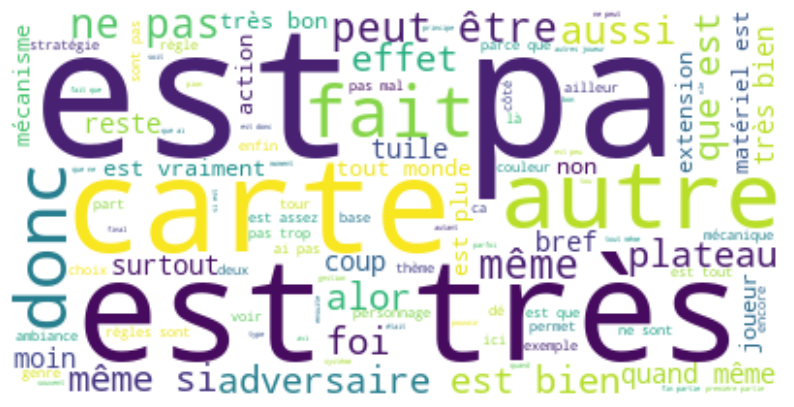

In [7]:
# Joindre tous les commentaires longs en une seule chaîne de texte
texte_long = " ".join(commentaires_longs)

# Créer un objet WordCloud
nuage_de_mots = WordCloud(background_color='white', max_words=100, contour_color='steelblue')

# Générer le nuage de mots
nuage_de_mots.generate(texte_long)

# Afficher le nuage de mots avec matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(nuage_de_mots, interpolation='bilinear')
plt.axis('off')  # Ne pas afficher les axes pour une meilleure visualisation
plt.show()

In [8]:
# Calculer les 100 mots les plus fréquents dans la chaîne de texte longue
mots_frequents = Counter(texte_long.split()).most_common(100)
for f in mots_frequents:
    print(f)

('est', 151621)
('pas', 84012)
('que', 68165)
('plus', 56458)
('ne', 47239)
('bien', 39507)
('très', 36147)
('sont', 31200)
('cartes', 30212)
('même', 27789)
('tout', 27554)
('si', 27131)
('peu', 26022)
('partie', 24925)
('joueurs', 24736)
('peut', 23760)
('fait', 23669)
('qu', 21988)
('ai', 21282)
('faire', 20457)
('être', 19492)
('bon', 18430)
('parties', 17508)
('jouer', 16502)
('donc', 15575)
('faut', 14491)
('autres', 14216)
('trop', 14086)
('règles', 13590)
('aussi', 13022)
('vraiment', 12595)
('assez', 12282)
('quand', 12139)
('moins', 11706)
('deux', 11646)
('joueur', 11542)
('points', 11520)
('tour', 10911)
('temps', 10435)
('là', 10401)
('avoir', 10192)
('fois', 10095)
('beaucoup', 10028)
('matériel', 9818)
('thème', 9814)
('plateau', 9552)
('petit', 9210)
('autre', 8946)
('carte', 8929)
('non', 8744)
('alors', 8710)
('encore', 8408)
('simple', 7945)
('tous', 7925)
('va', 7569)
('ont', 7551)
('toujours', 7537)
('choix', 7524)
('bonne', 7455)
('hasard', 7136)
('suis', 7031)
('

**Analyse de co-occurrence et réseaux de mots / N-grammes**

In [9]:
# Tokenisation
tokens = word_tokenize(texte_long, language='french')

# Génération des bigrammes
bigrammes = list(ngrams(tokens, 2))

# Comptage des bigrammes les plus fréquents
freq_bigrammes = Counter(bigrammes)
print(freq_bigrammes.most_common(15))

[(('est', 'pas'), 12769), (('est', 'très'), 7080), (('peut', 'être'), 5808), (('ne', 'pas'), 5345), (('même', 'si'), 4693), (('est', 'bien'), 4369), (('que', 'est'), 4148), (('quand', 'même'), 3885), (('très', 'bien'), 3562), (('est', 'vraiment'), 3173), (('tout', 'monde'), 3112), (('matériel', 'est'), 3058), (('est', 'plus'), 2949), (('très', 'bon'), 2928), (('est', 'que'), 2853)]


**Comparer le vocabulaire entre les différents utilisateurs.**

In [10]:

# Assurez-vous d'abord de remplacer les valeurs NaN par une chaîne vide ou par un placeholder approprié
df_grouped = avis_norm.fillna('')

# Ensuite, regroupez les commentaires par auteur et les concaténez en un seul texte, en s'assurant que tout est traité comme une chaîne
df_grouped = avis_norm.groupby('author')['comment_propre'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

# Limiter à 100 auteurs si nécessaire (vous avez mentionné 10 dans la demande initiale, mais utilisé 100 ici)
df_limited = df_grouped.head(100)

# Charger les stop words en français
stop_words_french = stopwords.words('french')

# Prétraitement et vectorisation TF-IDF avec les stop words français de nltk
vectorizer = TfidfVectorizer(stop_words=stop_words_french)
X = vectorizer.fit_transform(df_grouped['comment_propre'])

# Le reste du code reste inchangé
knn = NearestNeighbors(n_neighbors=4, metric='cosine')
knn.fit(X)

# Trouver les auteurs les plus proches pour chaque auteur, en ignorant le premier résultat
distances, indices = knn.kneighbors(X)

for i in range(len(df_grouped)):
    print(f"Auteurs les plus similaires à {df_grouped.iloc[i]['author']}:")
    for j in range(1, 4):  # Commence à 1 pour ignorer l'auto-recommandation et imprime les 3 suivants
        if j < len(df_grouped):  # Vérifie si l'indice est dans la plage
            print(f"- {df_grouped.iloc[indices[i, j]]['author']} avec une distance de {distances[i, j]:.2f}")
    print()

Auteurs les plus similaires à *FitzChevalerie*:
- Robbenblues avec une distance de 0.60
- meliadus94 avec une distance de 0.60
- Pifec avec une distance de 0.61

Auteurs les plus similaires à --- JD ---:
- Mati24 avec une distance de 0.00
- Matou Rdanoï avec une distance de 0.00
- Pehk avec une distance de 0.00

Auteurs les plus similaires à -Yo-:
- emmanuel.denis avec une distance de 0.00
- echow464 avec une distance de 0.00
- Godoftheark avec une distance de 0.00

Auteurs les plus similaires à 20.100:
- JJL avec une distance de 0.39
- O_cedar avec une distance de 0.39
- limp avec une distance de 0.40

Auteurs les plus similaires à 20cil:
- FlashMcQueen avec une distance de 0.64
- JJL avec une distance de 0.66
- prems avec une distance de 0.66

Auteurs les plus similaires à 26vince:
- emmanuel.denis avec une distance de 0.00
- echow464 avec une distance de 0.00
- Godoftheark avec une distance de 0.00

Auteurs les plus similaires à 3dman:
- JJL avec une distance de 0.61
- guilou05 avec

Auteurs les plus similaires à laurentbib:
- Pifec avec une distance de 0.56
- JJL avec une distance de 0.58
- momov avec une distance de 0.58

Auteurs les plus similaires à le Polack:
- limp avec une distance de 0.35
- prems avec une distance de 0.36
- JJL avec une distance de 0.38

Auteurs les plus similaires à le Zakhan noir:
- JJL avec une distance de 0.29
- lynkowsky avec une distance de 0.31
- pingouin avec une distance de 0.31

Auteurs les plus similaires à le broc:
- emmanuel.denis avec une distance de 0.00
- echow464 avec une distance de 0.00
- Godoftheark avec une distance de 0.00

Auteurs les plus similaires à le coach:
- Pifec avec une distance de 0.57
- allard92 avec une distance de 0.58
- guilou05 avec une distance de 0.58

Auteurs les plus similaires à le jardinier:
- Harry Cover avec une distance de 0.37
- Mattintheweb avec une distance de 0.38
- ludodelaludo avec une distance de 0.39

Auteurs les plus similaires à le roublard:
- lynkowsky avec une distance de 0.53
- JJL

- The Killer avec une distance de 0.39

Auteurs les plus similaires à vermithrax79:
- Bubu2015 avec une distance de 0.65
- ludodelaludo avec une distance de 0.65
- Shakkah avec une distance de 0.65

Auteurs les plus similaires à vik:
- morlockbob avec une distance de 0.41
- JJL avec une distance de 0.41
- meliadus94 avec une distance de 0.41

Auteurs les plus similaires à viking:
- Joker75 avec une distance de 0.37
- Lilian avec une distance de 0.39
- meliadus94 avec une distance de 0.39

Auteurs les plus similaires à vince47:
- O_cedar avec une distance de 0.58
- JJL avec une distance de 0.59
- prems avec une distance de 0.59

Auteurs les plus similaires à vince_jeux:
- Golden avec une distance de 0.62
- Pac avec une distance de 0.63
- meliadus94 avec une distance de 0.63

Auteurs les plus similaires à vinced:
- epave de pwasson avec une distance de 0.78
- grojaky avec une distance de 0.78
- ijonesjeux avec une distance de 0.79

Auteurs les plus similaires à vindix:
- ddbas avec une d

In [11]:
# Filtrer les commentaires de l'auteur 'Adouskar' et afficher les colonnes 'title_review' et 'comment'
print("Les commentaires de 20.100:")
print(avis_norm.loc[avis_norm['author'] == '20.100', ['title_review', 'comment','note']])

# Filtrer les commentaires de l'auteur 'echow464' et afficher les colonnes 'title_review' et 'comment'
print("\nLes commentaires de JJL :")
print(avis_norm.loc[avis_norm['author'] == 'JJL', ['title_review', 'comment','note']])


Les commentaires de 20.100:
                                  title_review  \
21108                        Plumage et ramage   
23506                                 Parfait?   
26299               Addicitf pas dans le dico?   
26717                              Magnifique!   
31850            Une petite perfection ludique   
35914                       Traîne en longueur   
40888                   Et en plus c'est Zoli!   
53234                    Ton 34, tu le gardes!   
53621                     Nostalgie, nostalgie   
64946              Ben un effort d'imagination   
100685                              Consensuel   
104974              Ficelle, selle ... de mer?   
106128                     20 minutes pas plus   
112191                          Le cow-boy mou   
112530                       Basari plus mieux   
113590                        Ultime défouloir   
114040                        C'est du Knizia?   
114292         Attention, mes mongols arrivent   
114816        C'est fi